# Whiskey Distillery

#### Brad Berning and Katie Hergenrother

CBE 40455: Final Project  
December 14, 2017

## Introduction

This project examines the batch scheduling associated with the distillation of whiskey. Because "hearts" are generally aged in barrels for multiple years following production before whiskey is ready to sell, this notebook will model this production of hearts. First, the general process will be sketched, before a brief analysis of a system producing two types of whiskey, one of which is higher quality and therefore requires additional time to distill.

## References

[1] “Whisky for Everyone.” Find out How Whisky Is Made, 2012, [http://www.whiskyforeveryone.com/whisky_basics/how_is_whisky_made.html](http://www.whiskyforeveryone.com/whisky_basics/how_is_whisky_made.html).

[2] The Editors of Encyclopædia Britannica. “Whiskey.” Encyclopædia Britannica, Encyclopædia Britannica, Inc., 10 Aug. 2016.

[3] “Bourbon, Whiskey, Vodka and Moonshine - How Much Yeast?” Copper Moonshine Still Kits - Clawhammer Supply, 2014, [http://www.clawhammersupply.com/blogs/moonshine-still-blog/11824025-bourbon-whiskey-vodka-and-moonshine-how-much-yeast](http://www.clawhammersupply.com/blogs/moonshine-still-blog/11824025-bourbon-whiskey-vodka-and-moonshine-how-much-yeast).

[4] “How Bourbon Whiskey Is Made.” How Bourbon Whiskey Is Made - Whisky.com, Whisky.com Media GmbH & Co. KG, 2017, [http://www.whisky.com/information/knowledge/production/overview/how-bourbon-whiskey-is-made.html](http://www.whisky.com/information/knowledge/production/overview/how-bourbon-whiskey-is-made.html).

[5] Hirsch, Irving. Manufacture of Whiskey, Brandy And Cordials. "First edition" Newark, N.J: Sherman Engineering Co., 1934.

## State Task Network Diagram

The following state task network diagram was developed in order to model the whiskey distillation process:

![](diagram1.jpg)

Of particular note is the "Mashing" process, in which 1/3 the volume is extracted as wort and draff after 1/3 of the process time, and another 1/3 of the volume after 2/3 of the process time. The final 1/3 of the volume is extracted at the end of the process time, but this is recycled as grist to be used in the next Mashing process - this retains desirable flavors and helps with quality control in keeping the batches consistent. However, because a given task cannot output identical states at different times, additional states and an additional task are required to model this constraint, as shown in this altered state task network diagram:

![](diagram2.jpg)

To model this Mashing process, "Draff 2" and "Wort 2" are also produced by the Mashing task after 1/3 of the process time. Then, these streams are run through a non-physical piece of equipment (Name Changer) that takes these states and changes them to "Draff" and "Wort", respectively, in an amount of time equal to 1/3 of the Mashing process time. Therefore, an extra unit of Draff and Wort appears after 2/3 of the Mashing process time, just as in the physical situation. In order to force this change, a large negative value is assigned to the price of both the "Draff 2" and "Wort 2" states (while the Draff and Wort states both have a value of zero).

The third output from the Mashing process is the grist to be reused and is called "Recycled Grist". A small amount of this is initialized at the start of the simulation (assumed to be taken from a previous Mashing process). An amount of this Recycled Grist is then both consumed at the beginning of every Mashing process and another amount is produced at the end of every Mashing process.

Now, to produce a model of the one-product system:

## Set up State Task Network

In [1]:
H = 70 # Time intervals in units of 1/3 hrs

# Construct state task network with a JSON structure containing all problem data
WD = { #Whiskey distillery STN
    
    'TIME':  range(0,H+1),
    
    # Define states
    'STATES': {
        
        # For input states, a positive price value represents a decrease in the profit of the process
        # For all other states, a positive price value represents an increase in the profit of the process,
        # and a negative price value represents a decrease in the profit of the process
        
        # Feed input states
        'Barley'   : {'capacity': 50, 'initial': 50, 'price':  5},
        'Corn'   : {'capacity': 100, 'initial': 100, 'price':  5},
        'Rye'   : {'capacity': 50, 'initial': 50, 'price':  5},
        'Water'   : {'capacity': 100, 'initial': 100, 'price':  0},        
        'Peat'    : {'capacity': 20, 'initial':   20, 'price': 5},        
        'HotWater'    : {'capacity': 300, 'initial':   300, 'price': 5},      
        'Yeast'    : {'capacity': 20, 'initial':   20, 'price': 5},
        
        # Intermediate states
        'Malt'    : {'capacity': 50, 'initial':   0, 'price': 0},
        'Grist'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Wort'    : {'capacity': 150, 'initial':   0, 'price': 0},
        'Wash'   : {'capacity': 150, 'initial':   0, 'price': 0},
        'LowWines'   : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Product states
        'Draff' : {'capacity': 100, 'initial': 0, 'price': 20},
        'Hearts'    : {'capacity': 400, 'initial':   0, 'price': 200},
        'Purge'    : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Recycle streams
        'Grist Recycle'    : {'capacity': 300, 'initial':   50, 'price': 0},
        'Feints'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Foreshots' : {'capacity': 100, 'initial':   0, 'price': 0},
        'Heads'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Tails'    : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Pseudo-states
        'Wort2' : {'capacity': 100, 'initial': 0, 'price': -1000},
        'Draff2' : {'capacity': 100, 'initial': 0, 'price': -1000},
        
    },
    
    # Designate which states are needed to complete a task and in what composition
    'ST_ARCS': {
        ('Barley',   'Malting')   : {'rho': 0.04},
        ('Rye',   'Malting')   : {'rho': 0.05},
        ('Corn',   'Malting')   : {'rho': 0.46},
        ('Water',   'Malting'): {'rho': 0.45},
        
        ('Malt',   'Drying'): {'rho': 0.999},
        ('Peat',    'Drying'): {'rho': 0.001},
        
        ('Grist',   'Mashing'): {'rho': 0.38},
        ('Grist Recycle',   'Mashing'): {'rho': 0.19},
        ('HotWater',    'Mashing'): {'rho': 0.43},
        
        ('Wort',   'Fermentation'): {'rho': 0.996},
        ('Yeast',   'Fermentation'): {'rho': 0.004},
        
        ('Wash', 'Distillation1'): {'rho': 1.0},
        
        ('LowWines',   'Distillation2'): {'rho': 1.0},
    
        ('Draff2',   'NameChange'): {'rho': 0.2},
        ('Wort2',   'NameChange'): {'rho': 0.8},
        
        ('Foreshots',   'Mixing'): {'rho': 0.14},
        ('Heads',   'Mixing'): {'rho': 0.43},
        ('Tails',   'Mixing'): {'rho': 0.29},
        ('Feints',   'Mixing'): {'rho': 0.14},
    },
    
    # Designate the state of material each task produces and in what composition
    'TS_ARCS': {
        ('Malting',    'Malt')    : {'dur': 16.0, 'rho': 1.0},
        
        ('Drying', 'Grist'): {'dur': 2.0, 'rho': 1.0},
        
        ('Mashing', 'Draff')   : {'dur': 1, 'rho': 0.066},
        ('Mashing', 'Wort') : {'dur': 1, 'rho': 0.264},
        ('Mashing', 'Draff2')   : {'dur': 1, 'rho': 0.066}, 
        ('Mashing', 'Wort2') : {'dur': 1, 'rho': 0.264},
        ('Mashing', 'Grist Recycle') : {'dur': 3, 'rho': 0.34},
        
        ('Fermentation', 'Wash')   : {'dur': 16, 'rho': 1.0},
        
        ('Distillation1', 'LowWines'): {'dur': 4, 'rho': 1.0},
        
        ('Distillation2', 'Foreshots') : {'dur': 4, 'rho': 0.1},
        ('Distillation2', 'Heads') : {'dur': 4, 'rho': 0.3},
        ('Distillation2', 'Hearts')   : {'dur': 4, 'rho': 0.3},
        ('Distillation2', 'Tails')   : {'dur': 4, 'rho': 0.2},
        ('Distillation2', 'Feints') : {'dur': 4, 'rho': 0.1},
        
        ('NameChange', 'Draff')   : {'dur': 1, 'rho': 0.2},
        ('NameChange', 'Wort') : {'dur': 1, 'rho': 0.8},
        
        ('Mixing', 'LowWines')   : {'dur': 1, 'rho': 0.99},
        ('Mixing', 'Purge') : {'dur': 1, 'rho': 0.01},
        
    },
    
    # Designate what equipment is needed to perform each task
    'UNIT_TASKS': {
        
        ('Germinating Cylinder', 'Malting')   : {'Bmin': 0, 'Bmax': 100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Kiln', 'Drying'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Mash Tun', 'Mashing'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Fermentor', 'Fermentation'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wash Still', 'Distillation1'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Spirits Still', 'Distillation2'): {'Bmin': 0, 'Bmax': 100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Name Changer', 'NameChange'): {'Bmin': 0, 'Bmax':  100000, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Mixer', 'Mixing'): {'Bmin': 0, 'Bmax':  100000, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

## State Task Network

In [2]:
# Define the state task network
STN = WD

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)


## Characterization of Tasks

In [3]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

## Characterization of States

In [4]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s


## Characterization of Units

In [5]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

## Pyomo Model

In [6]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()

# Compute the value earned by creating two products
model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES 
                                   if (s != 'Barley' and s != 'Water' and s != 'Corn' and s != 'Rye' and s !='Peat' and s !='HotWater' and s !='Yeast' and s != 'Grist Recycle')]) +
              sum([STATES[s]['price']*model.S[s,H] for s in STATES 
                                   if (s == 'Barley' or s == 'Water'or s =='Corn'or s =='Rye' or s =='Peat' or s =='HotWater' or s == 'Yeast' or s == 'Grist Recycle')]) - 
              STATES['Barley']['price']*WD['STATES']['Barley']['initial'] - 
              STATES['Corn']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Rye']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Grist Recycle']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Water']['price']*WD['STATES']['Water']['initial'] -
              STATES['Peat']['price']*WD['STATES']['Peat']['initial'] -
              STATES['HotWater']['price']*WD['STATES']['HotWater']['initial'] -
              STATES['Yeast']['price']*WD['STATES']['Yeast']['initial'])

    # Value calculation:

        # Compute the amount of each intermediate and product remaining at the end of the time frame 
            #and the cost associated with these states
    
        # Compute the amount of each feed material used during the time frame 
            #and the cost associated with using the material in production
        
        # Subtract the cost of feed material needed for an optimal profit 
            #from the revenue generated by making products
               
# Compute the cost               
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 
                    
# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Konkili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
        
SolverFactory('glpk').solve(model).write()
               

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 24929.9091696909
  Upper bound: 24929.9091696909
  Number of objectives: 1
  Number of constraints: 5407
  Number of variables: 3269
  Number of nonzeros: 14315
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 735
      Number of created subproblems: 735
  Error rc: 0
  Time: 1.0367720127105713
# ----------------------------------------------------------
#   Solution Information
# --

## Analysis

## Profitability

In [7]:
print("Value of State Inventories = {0:12.2f}".format(model.Value()))
#print("  Cost of Unit Assignments = {0:12.2f}".format(model.Cost()))
#print("             Net Objective = {0:12.2f}".format(model.Value() - model.Cost()))

net = model.Value() - model.Cost()

# The net profit of the production process is found by subtracting the costs from the revenue

Value of State Inventories =     24929.91


## State Inventories

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# Construct a table of data for the amount of each state at any time interval
pd.DataFrame([[model.S[s,t]() for s in STATES.keys()] for t in TIME], columns = STATES.keys(), index = TIME)

,Barley,Corn,Rye,Water,Peat,HotWater,Yeast,Malt,Grist,Wort,...,Draff,Hearts,Purge,Grist Recycle,Feints,Foreshots,Heads,Tails,Wort2,Draff2
0,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
1,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
2,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
3,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
4,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
5,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
6,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
7,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
8,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
9,46.004000,54.0460,45.005000,55.045000,20.00000,300.000000,20.000000,0.0,0.000000e+00,0.000000e+00,...,0.00000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00


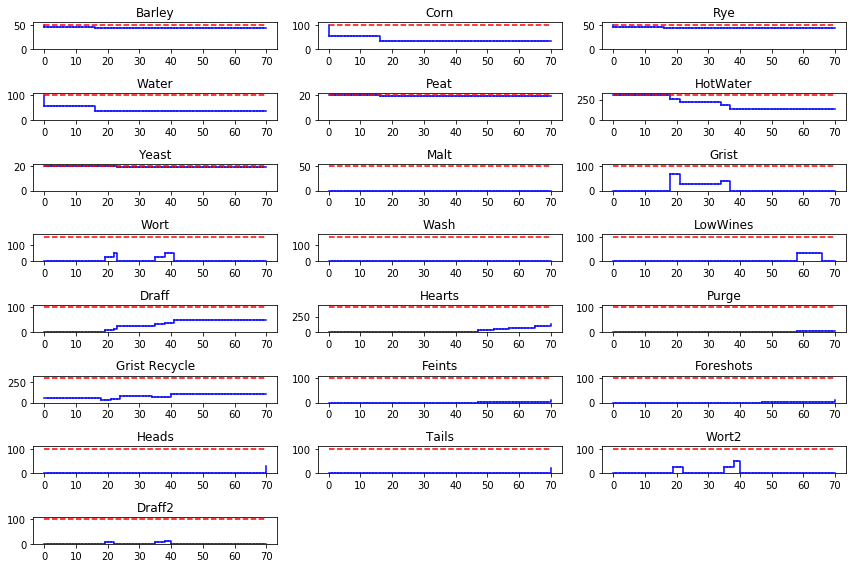

In [9]:
# Graphically display the amount of each state at any time interval

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

## Unit Assignment

In [10]:
# Create a table of tasks assigned to each piece of equipment during each time interval
UnitAssignment = pd.DataFrame({j:[None for t in TIME] for j in UNITS},index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t-p[i] >= 0:
                    if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                        UnitAssignment.loc[t,j] = None               
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                UnitAssignment.loc[t,j] = (i,model.B[i,j,t]())

UnitAssignment

,Fermentor,Germinating Cylinder,Kiln,Mash Tun,Mixer,Name Changer,Spirits Still,Wash Still
0,None,"(Malting, 99.9000000000014)",None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None


## Unit Batch Inventories

In [11]:
# Create a table of the batch sizes run in each piece of equipment during a time interval
pd.DataFrame([[model.Q[j,t]() for j in UNITS] for t in TIME], columns = UNITS, index = TIME)

,Germinating Cylinder,Mixer,Kiln,Spirits Still,Fermentor,Name Changer,Mash Tun,Wash Still
0,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
5,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
6,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
7,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
8,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
9,9.990000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


## Gantt Chart

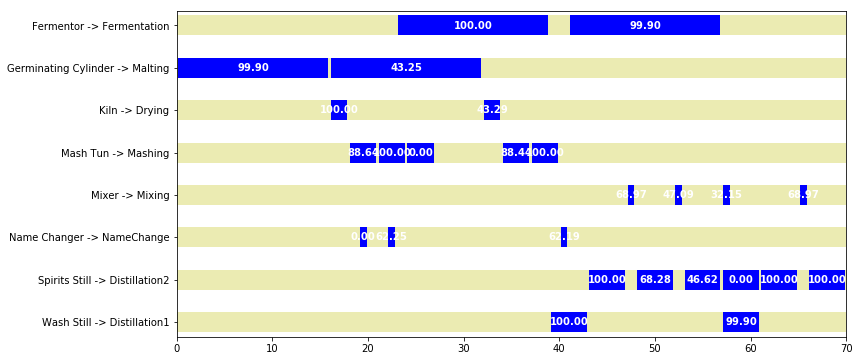

In [12]:
# Visually display the scheduling of each piece of equipment to a given task
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.2f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

By examination of the Gantt Chart, this process runs roughly as expected. The amount of product generated is largely driven by the size of the Malting stage (because this process requires a large amount of time). This simulation creates the optimum amount of malt that may be used within the specified time horizon before stopping this task, before then proceeding to make use of this malt in a way that maximizes profit within the time horizon.

Now that the process for creating one whiskey product has been modeled, an additional model which examines the creation of two different products will be examined. This new product requires additional time in distillation, yet is of a higher quality and therefore a higher price may be charged.

In order to model this new system, the state task network diagram is altered. Specifically, new processes must be added following the fermentation stage in order to differentiate between the two products: Distillation1_1 and Distillation2_1 for product 1, and Distillation1_2 and Distillation2_2 for product 2. Finally, the low wines, foreshots, feints, heads, and tails must all be separated between the two products, thereby requiring the addition off another state for all of these states following the Distillation1 process.

## Distilling Two Products

In [13]:
H = 70 # Time intervals

# Construct state task network with a JSON structure containing all problem data
WD = { #Whiskey distillery STN
    
    'TIME':  range(0,H+1),
    
    # Define states
    'STATES': {
        
        # For input states, a positive price value represents a decrease in the profit of the process
        # For all other states, a positive price value represents an increase in the profit of the process,
        # and a negative price value represents a decrease in the profit of the process
        
        # Feed input states
        'Barley'   : {'capacity': 50, 'initial': 50, 'price':  5},
        'Corn'   : {'capacity': 100, 'initial': 100, 'price':  5},
        'Rye'   : {'capacity': 50, 'initial': 50, 'price':  5},
        'Water'   : {'capacity': 100, 'initial': 100, 'price':  0},
        'Peat'    : {'capacity': 20, 'initial': 20, 'price': 5},
        'HotWater'    : {'capacity': 300, 'initial':   300, 'price': 5},
        'Yeast'    : {'capacity': 20, 'initial':   20, 'price': 5},
        
        # Intermediate states
        'Malt'    : {'capacity': 50, 'initial':   0, 'price': 0},
        'Grist'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Wort'    : {'capacity': 150, 'initial':   0, 'price': 0},
        'Wash'   : {'capacity': 150, 'initial':   0, 'price': 0},
        
        'LowWines1'   : {'capacity': 100, 'initial':   0, 'price': 0},
        'LowWines2'   : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Product states
        'Draff' : {'capacity': 100, 'initial': 0, 'price': 20},
        'Hearts1'    : {'capacity': 400, 'initial':   0, 'price': 200},
        'Purge1'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Hearts2'    : {'capacity': 400, 'initial':   0, 'price': 600},
        'Purge2'    : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Recycle streams
        'Grist Recycle'    : {'capacity': 300, 'initial':   50, 'price': 0},
        'Feints1'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Foreshots1' : {'capacity': 100, 'initial':   0, 'price': 0},
        'Heads1'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Tails1'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Feints2'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Foreshots2' : {'capacity': 100, 'initial':   0, 'price': 0},
        'Heads2'    : {'capacity': 100, 'initial':   0, 'price': 0},
        'Tails2'    : {'capacity': 100, 'initial':   0, 'price': 0},
        
        # Pseudo-states
        'Wort2' : {'capacity': 100, 'initial': 0, 'price': -1000},
        'Draff2' : {'capacity': 100, 'initial': 0, 'price': -1000},
        
    },
    
    # Designate which states are needed to complete a task and in what composition
    'ST_ARCS': {
        ('Barley',   'Malting')   : {'rho': 0.04},
        ('Rye',   'Malting')   : {'rho': 0.05},
        ('Corn',   'Malting')   : {'rho': 0.46},
        ('Water',   'Malting'): {'rho': 0.45},
        
        ('Malt',   'Drying'): {'rho': 0.999},
        ('Peat',    'Drying'): {'rho': 0.001},
        
        ('Grist',   'Mashing'): {'rho': 0.38},
        ('Grist Recycle',   'Mashing'): {'rho': 0.19},
        ('HotWater',    'Mashing'): {'rho': 0.43},
        
        ('Wort',   'Fermentation'): {'rho': 0.996},
        ('Yeast',   'Fermentation'): {'rho': 0.004},
        
        ('Wash', 'Distillation1_1'): {'rho': 1.0},
        ('Wash', 'Distillation1_2'): {'rho': 1.0},
        
        ('LowWines1',   'Distillation2_1'): {'rho': 1.0},
        ('LowWines2',   'Distillation2_2'): {'rho': 1.0},
        
    
        ('Draff2',   'NameChange'): {'rho': 0.2},
        ('Wort2',   'NameChange'): {'rho': 0.8},
        
        ('Foreshots1',   'Mixing1'): {'rho': 0.14},
        ('Heads1',   'Mixing1'): {'rho': 0.43},
        ('Tails1',   'Mixing1'): {'rho': 0.29},
        ('Feints1',   'Mixing1'): {'rho': 0.14},
        
        ('Foreshots2',   'Mixing2'): {'rho': 0.14},
        ('Heads2',   'Mixing2'): {'rho': 0.43},
        ('Tails2',   'Mixing2'): {'rho': 0.29},
        ('Feints2',   'Mixing2'): {'rho': 0.14},
    },
    
    # Designate the state of material each task produces and in what composition
    'TS_ARCS': {
        ('Malting',    'Malt')    : {'dur': 16.0, 'rho': 1.0},
        
        ('Drying', 'Grist'): {'dur': 2.0, 'rho': 1.0},
        
        ('Mashing', 'Draff')   : {'dur': 1, 'rho': 0.066},
        ('Mashing', 'Wort') : {'dur': 1, 'rho': 0.264},
        ('Mashing', 'Draff2')   : {'dur': 1, 'rho': 0.066},
        ('Mashing', 'Wort2') : {'dur': 1, 'rho': 0.264},
        ('Mashing', 'Grist Recycle') : {'dur': 3, 'rho': 0.34},
        
        ('Fermentation', 'Wash')   : {'dur': 16, 'rho': 1.0},
        
        ('Distillation1_1', 'LowWines1'): {'dur': 4, 'rho': 1.0},
        ('Distillation1_2', 'LowWines2'): {'dur': 8, 'rho': 1.0},
        
        ('Distillation2_1', 'Foreshots1') : {'dur': 4, 'rho': 0.1},
        ('Distillation2_1', 'Heads1') : {'dur': 4, 'rho': 0.3},
        ('Distillation2_1', 'Hearts1')   : {'dur': 4, 'rho': 0.3},
        ('Distillation2_1', 'Tails1')   : {'dur': 4, 'rho': 0.2},
        ('Distillation2_1', 'Feints1') : {'dur': 4, 'rho': 0.1},
        
        ('Distillation2_2', 'Foreshots2') : {'dur': 8, 'rho': 0.1},
        ('Distillation2_2', 'Heads2') : {'dur': 8, 'rho': 0.3},
        ('Distillation2_2', 'Hearts2')   : {'dur': 8, 'rho': 0.3},
        ('Distillation2_2', 'Tails2')   : {'dur': 8, 'rho': 0.2},
        ('Distillation2_2', 'Feints2') : {'dur': 8, 'rho': 0.1},
        
        ('NameChange', 'Draff')   : {'dur': 1, 'rho': 0.2},
        ('NameChange', 'Wort') : {'dur': 1, 'rho': 0.8},
        
        ('Mixing1', 'LowWines1')   : {'dur': 1, 'rho': 0.99},
        ('Mixing1', 'Purge1') : {'dur': 1, 'rho': 0.01},
        
        ('Mixing2', 'LowWines2')   : {'dur': 1, 'rho': 0.99},
        ('Mixing2', 'Purge2') : {'dur': 1, 'rho': 0.01},
        
    },
    
    # Designate what equipment is needed to perform each task
    'UNIT_TASKS': {
        
        ('Germinating Cylinder', 'Malting')   : {'Bmin': 0, 'Bmax': 100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Kiln', 'Drying'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Mash Tun', 'Mashing'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Fermentor', 'Fermentation'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wash Still', 'Distillation1_1'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Spirits Still', 'Distillation2_1'): {'Bmin': 0, 'Bmax': 100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wash Still', 'Distillation1_2'): {'Bmin': 0, 'Bmax':  100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Spirits Still', 'Distillation2_2'): {'Bmin': 0, 'Bmax': 100, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Name Changer', 'NameChange'): {'Bmin': 0, 'Bmax':  100000, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Mixer', 'Mixing1'): {'Bmin': 0, 'Bmax':  100000, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Mixer', 'Mixing2'): {'Bmin': 0, 'Bmax':  100000, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

## State Task Network for Two Products

In [14]:
# Define the state task network
STN = WD

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)


## Characterization of Tasks for Two Products

In [15]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

## Characterization of States for Two Products

In [16]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s


## Characterization of Units for Two Products

In [17]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

In [18]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()

# Compute the value earned by creating two products
model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES 
                                   if (s != 'Barley' and s != 'Water' and s != 'Corn' and s != 'Rye' and s !='Peat' and s !='HotWater' and s !='Yeast' and s != 'Grist Recycle')]) +
              sum([STATES[s]['price']*model.S[s,H] for s in STATES 
                                   if (s == 'Barley' or s == 'Water'or s =='Corn'or s =='Rye' or s =='Peat' or s =='HotWater' or s == 'Yeast' or s == 'Grist Recycle')]) - 
              STATES['Barley']['price']*WD['STATES']['Barley']['initial'] - 
              STATES['Corn']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Rye']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Grist Recycle']['price']*WD['STATES']['Barley']['initial'] -
              STATES['Water']['price']*WD['STATES']['Water']['initial'] -
              STATES['Peat']['price']*WD['STATES']['Peat']['initial'] -
              STATES['HotWater']['price']*WD['STATES']['HotWater']['initial'] -
              STATES['Yeast']['price']*WD['STATES']['Yeast']['initial'])

    # Value calculation:

        # Compute the amount of each intermediate and product remaining at the end of the time frame 
            #and the cost associated with these states
    
        # Compute the amount of each feed material used during the time frame 
            #and the cost associated with using the material in production
        
        # Subtract the cost of feed material needed for an optimal profit 
            #from the revenue generated by making products
               
# Compute the cost               
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 
                    
# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Konkili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
        
SolverFactory('glpk').solve(model).write()
               

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 36325.9462405956
  Upper bound: 36325.9462405956
  Number of objectives: 1
  Number of constraints: 6827
  Number of variables: 4192
  Number of nonzeros: 18943
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 4757
      Number of created subproblems: 4757
  Error rc: 0
  Time: 9.004477977752686
# ----------------------------------------------------------
#   Solution Information
# -

## Profitability for Two Products

In [19]:
print("Value of State Inventories = {0:12.2f}".format(model.Value()))
#print("  Cost of Unit Assignments = {0:12.2f}".format(model.Cost()))
#print("             Net Objective = {0:12.2f}".format(model.Value() - model.Cost()))

net = model.Value() - model.Cost()

# The net profit of the production process is found by subtracting the costs from the revenue

Value of State Inventories =     36325.95


## State Inventories for Two Products

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# Construct a table of data for the amount of each state at any time interval
pd.DataFrame([[model.S[s,t]() for s in STATES.keys()] for t in TIME], columns = STATES.keys(), index = TIME)

,Barley,Corn,Rye,Water,Peat,HotWater,Yeast,Malt,Grist,Wort,...,Feints1,Foreshots1,Heads1,Tails1,Feints2,Foreshots2,Heads2,Tails2,Wort2,Draff2
0,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
3,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
4,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
5,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
6,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
7,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
8,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
9,46.004000,54.046000,45.005000,55.045000,20.000000,300.000000,20.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


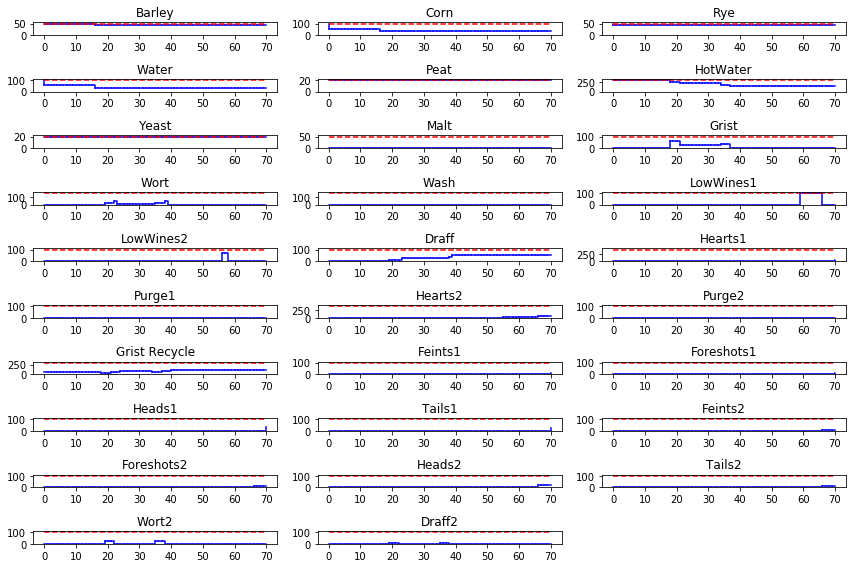

In [21]:
# Graphically display the amount of each state at any time interval

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

## Unit Assignment for Two Products

In [22]:
# Create a table of tasks assigned to each piece of equipment during each time interval
UnitAssignment = pd.DataFrame({j:[None for t in TIME] for j in UNITS},index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t-p[i] >= 0:
                    if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                        UnitAssignment.loc[t,j] = None               
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                UnitAssignment.loc[t,j] = (i,model.B[i,j,t]())

UnitAssignment

,Fermentor,Germinating Cylinder,Kiln,Mash Tun,Mixer,Name Changer,Spirits Still,Wash Still
0,None,"(Malting, 99.9000000000014)",None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None


## Unit Batch Inventories for Two Products

In [23]:
# Create a table of the batch sizes run in each piece of equipment during a time interval
pd.DataFrame([[model.Q[j,t]() for j in UNITS] for t in TIME], columns = UNITS, index = TIME)

,Germinating Cylinder,Mixer,Kiln,Spirits Still,Fermentor,Name Changer,Mash Tun,Wash Still
0,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,9.990000e+01,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Gantt Chart for Two Products

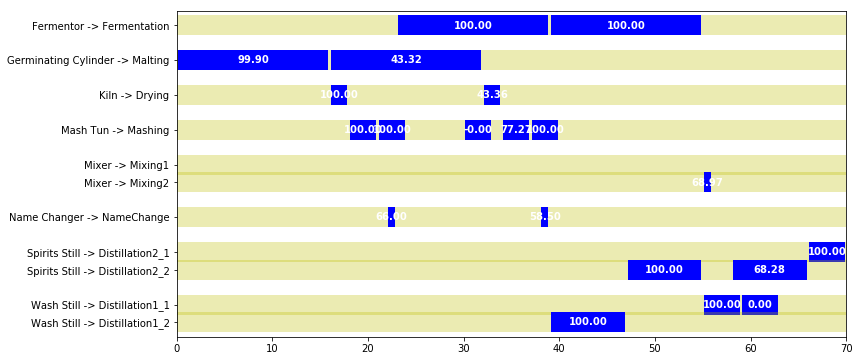

In [24]:
# Visually display the scheduling of each piece of equipment to a given task
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.2f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

From inspection of this Gantt chart, it becomes clear that the system optimizes profit when the higher quality (and higher price) product 2 is produced. However, some amount of product 1 is produced due to the horizon ending, as the simulation takes advantage of the lesser amount of time required to produce product 1. In other words, if this simulation was carried out through an infinite amount of time, it appears product 1 would never be created. This information would prove useful if production data needed maximized and inventory data needed minimized in order to meet a deadline at a quarter's end. Additionally, this information could be used to schedule the most efficient use of resources ahead of a planned plant-wide outage, due to an event such as important maintenance or a holiday.